<a href="https://colab.research.google.com/github/Soumayas/Calcul_des_incertitudes_de_mesure_en_utilisant_ML/blob/main/AutoML_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup and Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve

# Optionnel : Pour ignorer certains warnings pandas
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Cell 2 : Chargement des données
ABUNDANCE_PATH = "taxonomic_profiles (2).csv"
METADATA_PATH = "hmp2_metadata_2018-08-20 (1).csv"
TARGET_COLUMN = "diagnosis"

abundance = pd.read_csv(ABUNDANCE_PATH, sep=";")
sample_columns = [col for col in abundance.columns if col not in ["#OTU ID", "taxonomy"]]
abundance_data = abundance[sample_columns].T
abundance_data.index.name = "sample_id"
abundance_data = abundance_data.apply(pd.to_numeric, errors="coerce").fillna(0)

metadata = pd.read_csv(METADATA_PATH, sep=";")
metadata = metadata.set_index("External ID")
common_samples = abundance_data.index.intersection(metadata.index)
abundance_data = abundance_data.loc[common_samples]
metadata = metadata.loc[common_samples]

df = abundance_data.copy()
df["target"] = metadata[TARGET_COLUMN]
df = df[df["target"].isin(["UC", "CD"])]  # Seulement UC et CD
df["target"] = df["target"].map({"CD": 1, "UC": 0})

print(f"Loaded {df.shape[0]} samples, {df.shape[1]-1} features. Target balance:")
display(df["target"].value_counts())

Loaded 132 samples, 982 features. Target balance:


target
1    86
0    46
Name: count, dtype: int64

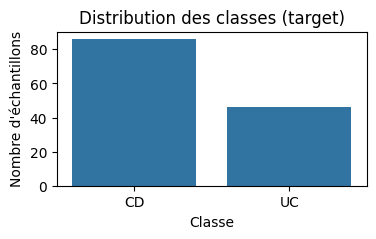

In [ ]:
plt.figure(figsize=(4,2))
sns.countplot(x=df["target"].map({0:"UC", 1:"CD"}))
plt.title("Distribution des classes (target)")
plt.xlabel("Classe")
plt.ylabel("Nombre d'échantillons")
plt.show()

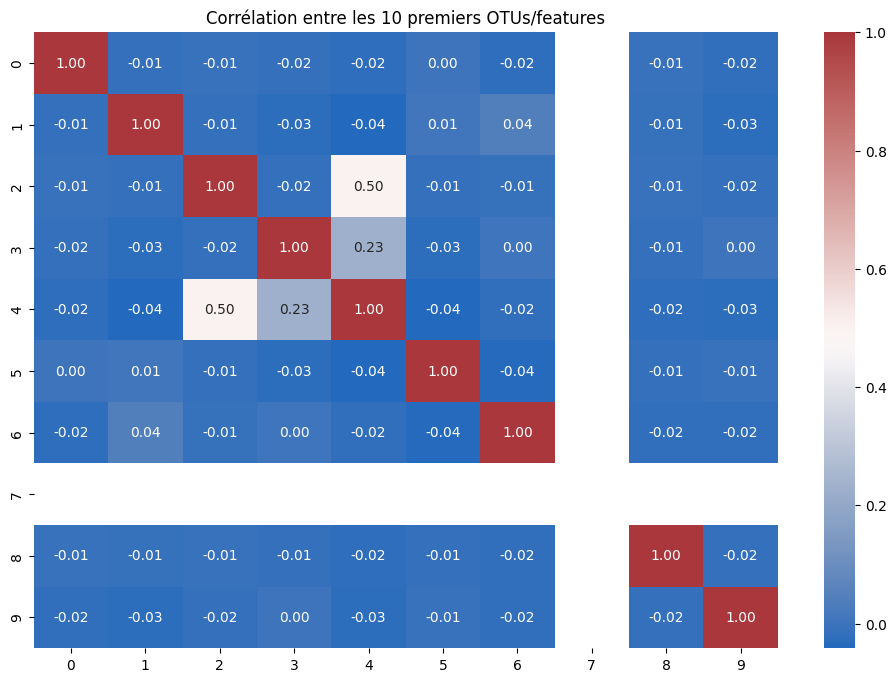

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df.iloc[:,:10].corr(), annot=True, fmt=".2f", cmap="vlag")
plt.title("Corrélation entre les 10 premiers OTUs/features")
plt.show()

In [ ]:
X = df.drop("target", axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print("Taille train:", X_train.shape, "Taille test:", X_test.shape)

Taille train: (105, 982) Taille test: (27, 982)


In [ ]:
# H2O AutoML

h2o.init()
train_h2o = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
test_h2o  = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))
x_cols = list(X.columns)
y_col = "target"
train_h2o[y_col] = train_h2o[y_col].asfactor()
test_h2o[y_col]  = test_h2o[y_col].asfactor()

aml = H2OAutoML(max_runtime_secs=300, seed=1, nfolds=5, balance_classes=True)
aml.train(x=x_cols, y=y_col, training_frame=train_h2o)

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,2 hours 39 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,4 months and 7 days
H2O_cluster_name:,H2O_from_python_sabbes_t1wjhg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,28.58 Gb
H2O_cluster_total_cores:,32
H2O_cluster_allowed_cores:,32
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
10:54:23.350: _train param, Dropping bad and constant columns: [908, 593, 594, 353, 474, 233, 355, 631, 116, 117, 238, 239, 635, 756, 92, 119, 878, 94, 517, 639, 99, 919, 13, 15, 18, 361, 242, 485, 123, 244, 882, 245, 883, 400, 884, 401, 7, 524, 129, 525, 646, 921, 406, 527, 804, 926, 20, 807, 928, 28, 29, 374, 495, 770, 892, 256, 498, 652, 379, 896, 930, 139, 414, 899, 659, 937, 819, 141, 142, 143, 385, 386, 145, 420, 267, 542, 784, 147, 148, 665, 666, 820, 425, 547, 822, 702, 944, 307, 428, 549, 41, 43, 44, 391, 670, 154, 396, 550, 792, 430, 310, 278, 399, 556, 678, 316, 833, 956, 319, 715, 958, 838, 719, 55, 56, 164, 165, 561, 442, 322, 840, 325, 568, 722, 327, 449, 208, 329, 967, 605, 726, 62, 64, 608, 66, 290, 174, 570, 691, 176, 451, 573, 694, 211, 453, 212, 335, 457, 579, 4

key,value
Stacking strategy,cross_validation
Number of base models (used / total),8/93
# GBM base models (used / total),0/38
# XGBoost base models (used / total),0/16
# DeepLearning base models (used / total),8/36
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [ ]:
#  Résultats & leaderboard
lb = aml.leaderboard
print("===== Leaderboard (top modèles) =====")
display(lb.as_data_frame().head(5))
print("Meilleur modèle :", aml.leader.model_id)

===== Leaderboard (top modèles) =====


,model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
0,StackedEnsemble_BestOfFamily_7_AutoML_1_202508...,0.836645,0.470623,0.909426,0.273847,0.395358,0.156308
1,GBM_grid_1_AutoML_1_20250804_81428_model_23,0.818760,0.499768,0.901919,0.243045,0.411453,0.169293
2,DeepLearning_grid_3_AutoML_1_20250804_81428_mo...,0.813394,2.357435,0.848499,0.259141,0.468462,0.219457
3,StackedEnsemble_AllModels_6_AutoML_1_20250804_...,0.810016,0.499525,0.856840,0.284976,0.400322,0.160257
4,StackedEnsemble_AllModels_5_AutoML_1_20250804_...,0.808029,0.589061,0.868454,0.298490,0.430539,0.185364


Meilleur modèle : StackedEnsemble_BestOfFamily_7_AutoML_1_20250804_81428


In [ ]:
#  Résultats & leaderboard
lb = aml.leaderboard
print("===== Leaderboard (top modèles) =====")
display(lb.as_data_frame().head(5))
print("Meilleur modèle :", aml.leader.model_id)

===== Leaderboard (top modèles) =====


,model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
0,StackedEnsemble_AllModels_4_AutoML_2_20250804_...,0.867250,0.443226,0.919273,0.198927,0.375553,0.141040
1,StackedEnsemble_BestOfFamily_6_AutoML_2_202508...,0.852544,0.453248,0.918180,0.248013,0.386872,0.149670
2,StackedEnsemble_AllModels_6_AutoML_2_20250804_...,0.851749,0.458309,0.907617,0.265302,0.384153,0.147573
3,StackedEnsemble_Best1000_1_AutoML_2_20250804_1...,0.850159,0.467840,0.903838,0.225954,0.385890,0.148911
4,StackedEnsemble_BestOfFamily_5_AutoML_2_202508...,0.842607,0.519460,0.917199,0.319356,0.414585,0.171881


Meilleur modèle : StackedEnsemble_AllModels_4_AutoML_2_20250804_105423


In [ ]:
# Prédictions et métriques
preds = aml.leader.predict(test_h2o)
preds_df = preds.as_data_frame()
y_test_arr = np.array(y_test)
y_pred = preds_df["predict"].astype(int).values

acc = accuracy_score(y_test_arr, y_pred)
f1  = f1_score(y_test_arr, y_pred)
auc = roc_auc_score(y_test_arr, preds_df["p1"].values)
cm = confusion_matrix(y_test_arr, y_pred)

print(f"\nTest Accuracy: {acc:.3f}")
print(f"Test F1 Score: {f1:.3f}")
print(f"Test ROC AUC: {auc:.3f}")
print("Confusion matrix:\n", cm)

stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%

Test Accuracy: 0.704
Test F1 Score: 0.765
Test ROC AUC: 0.765
Confusion matrix:
 [[ 6  3]
 [ 5 13]]


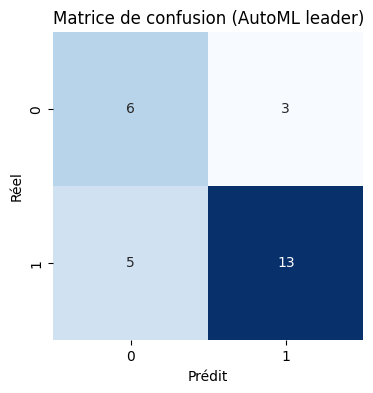

In [ ]:
# Matrice de confusion graphique
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion (AutoML leader)")
plt.show()

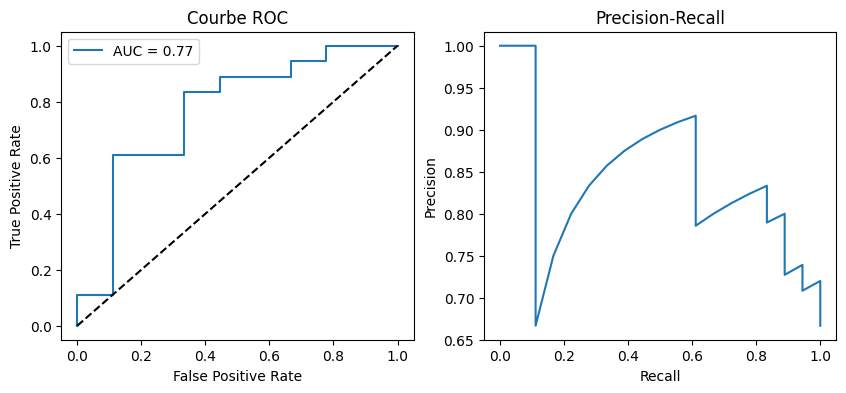

In [ ]:
#  Courbe ROC & Precision-Recall
fpr, tpr, _ = roc_curve(y_test_arr, preds_df["p1"].values)
prec, rec, _ = precision_recall_curve(y_test_arr, preds_df["p1"].values)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC")
plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.show()

In [ ]:
#  Importance des variables (features)
# Support: only some H2O models have variable_importances
try:
    vi = aml.leader.varimp(use_pandas=True)
    plt.figure(figsize=(8,5))
    sns.barplot(y=vi["variable"].head(15), x=vi["relative_importance"].head(15), orient="h")
    plt.xlabel("Importance relative")
    plt.ylabel("Feature (OTU)")
    plt.title("Importance des 15 variables principales (leader AutoML)")
    plt.show()
except Exception as e:
    print("Pas d'importance de variables disponible pour ce modèle.", e)

Pas d'importance de variables disponible pour ce modèle. 'NoneType' object is not subscriptable


<Figure size 800x500 with 0 Axes>

In [ ]:
#  Explicabilité SHAP
# Pour les modèles compatibles (Tree-based, GBM, XGBoost), h2o propose SHAP
try:
    shap_df = aml.leader.predict_contributions(test_h2o).as_data_frame()
    shap_vals = shap_df.iloc[:,:-1].values  # Sans la colonne BiasTerm
    plt.figure(figsize=(10,5))
    plt.boxplot(shap_vals, vert=False, labels=shap_df.columns[:-1])
    plt.title("SHAP values (test set, 10 premières features)")
    plt.xlim(-1, 1)
    plt.xlabel("Valeur SHAP")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("SHAP indisponible pour ce modèle :", e)

contributions progress: | (failed)
SHAP indisponible pour ce modèle : Job with key $03017f00000132d4ffffffff$_a896bb1d6bb5a04b834cf7b15bfb45ad failed with an exception: water.exceptions.H2OIllegalArgumentException: unimplemented: StackedEnsemble supports contribution calculation only with a background frame.
stacktrace: 
water.exceptions.H2OIllegalArgumentException: unimplemented: StackedEnsemble supports contribution calculation only with a background frame.
	at water.H2O.unimpl(H2O.java:1385)
	at hex.ensemble.StackedEnsembleModel.scoreContributions(StackedEnsembleModel.java:279)
	at water.api.ModelMetricsHandler$1.compute2(ModelMetricsHandler.java:549)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1704)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:976)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1479)
	at jsr166y.ForkJoinWorkerThread.run(Fo

In [ ]:
h2o.cluster().shutdown(prompt=False)

H2O session _sid_be4c closed.


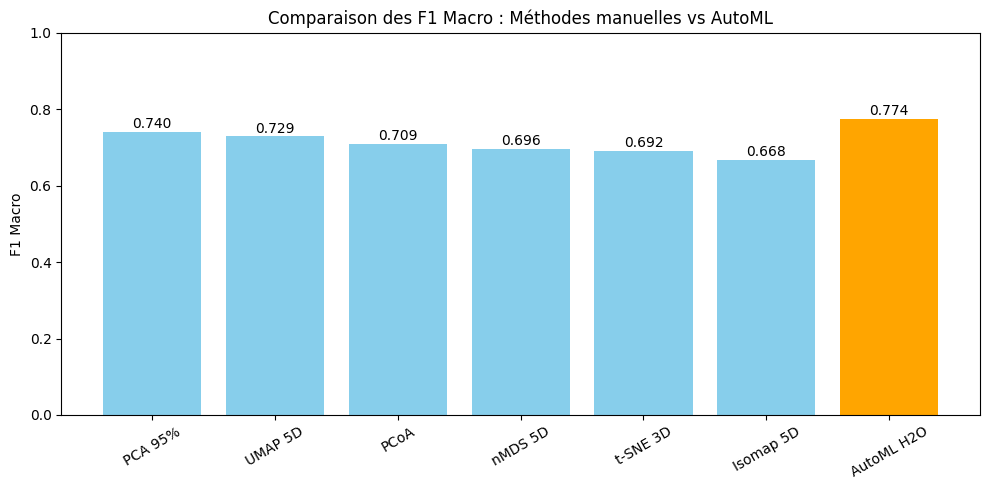

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

labels = [
    "PCA 95%",
    "UMAP 5D",
    "PCoA",
    "nMDS 5D",
    "t-SNE 3D",
    "Isomap 5D",
    "AutoML H2O"
]
f1_scores = [
    0.740,
    0.729,
    0.709,
    0.696,
    0.692,
    0.668,
    0.774   #  résultat AutoML
]

plt.figure(figsize=(10, 5))
plt.bar(labels, f1_scores, color=['skyblue']*6 + ['orange'])
plt.ylabel("F1 Macro")
plt.title("Comparaison des F1 Macro : Méthodes manuelles vs AutoML")
plt.ylim(0, 1)
for i, v in enumerate(f1_scores):
    plt.text(i, v+0.01, f"{v:.3f}", ha='center')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('figures/comparaison_f1.png')
plt.show()


## 🧬 Comparaison des méthodes de classification microbiome UC/CD

### 1. Objectif

Comparer différentes approches de classification pour distinguer les diagnostics UC (rectocolite) et CD (Crohn) à partir des profils microbiens, en utilisant :
- Des pipelines manuels avancés (réduction de dimension, normalisation, classifieurs classiques)
- Un pipeline automatisé AutoML (H2O)

---

### 2. Méthodes testées

#### **Pipelines manuels**
- Réduction de dimension : PCA, UMAP, t-SNE, PCoA, Isomap, nMDS
- Normalisations : CSS, TMM
- Classification (RandomForest, SVM…)
- Optimisation des hyperparamètres et équilibrage (SMOTE)
- Évaluation : **F1 Macro (SMOTE), robustesse (std), temps**

#### **AutoML (H2O)**
- Modèles testés automatiquement (GBM, RF, GLM, empilement…)
- Prise en charge automatique des hyperparamètres, du prétraitement, etc.
- **Durée d'exécution : ~5 minutes pour l'exploration automatique des modèles**
- Évaluation : F1-score, accuracy, ROC AUC

---

### 3. Résultats principaux

| Méthode                | F1 Macro (SMOTE) | Notes                         |
|------------------------|------------------|-------------------------------|
| UMAP 5D + TMM (manuel) | 0.841 ± 0.052    | Meilleure méthode manuelle    |
| PCA 95%                | 0.740            |                               |
| t-SNE 3D               | 0.692            |                               |
| Isomap 5D              | 0.668            |                               |
| **AutoML H2O**         | **0.774**        | Sans réduction de dimension   |

- **AutoML H2O** donne un score F1 compétitif (0.774), comparable ou supérieur à plusieurs méthodes classiques, mais **reste légèrement inférieur à la meilleure combinaison manuelle optimisée (0.841)**.
- Les pipelines manuels combinant **réduction de dimension non linéaire (UMAP)** et **normalisation adaptée (TMM)** offrent la meilleure performance sur ces données.

---

### 4. Visualisation comparative

*voir image ci dessus*

---

### 5. Interprétations & recommandations

- Les performances supérieures du pipeline UMAP+TMM montrent l’intérêt des techniques avancées de prétraitement sur des données microbiome complexes.
- **AutoML** est un outil puissant pour automatiser le benchmark et obtenir rapidement des résultats solides, mais peut nécessiter des étapes manuelles (réduction de dimension, normalisation spécifique) pour atteindre l’optimum.
- Il est recommandé de **combiner les deux approches** :
  - Utiliser AutoML pour le screening rapide,
  - Optimiser manuellement avec les techniques les plus adaptées aux spécificités du domaine.

---

### 6. Conclusion

- **La meilleure performance globale est obtenue par le pipeline manuel optimisé (UMAP+TMM), avec un F1 Macro de 0.841.**
- **AutoML H2O permet d’obtenir rapidement des scores proches (F1 = 0.774) sans tuning, mais ne surpasse pas l’approche manuelle optimisée sur ce jeu de données.**
- L’exécution du pipeline AutoML complet prend environ 5 minutes sur cette configuration, ce qui reste très raisonnable compte tenu du nombre de modèles et de la recherche automatique.
- Les résultats démontrent l’importance du prétraitement avancé en microbiome, mais valident aussi l’apport d’AutoML pour l’exploration initiale ou les jeux moins complexes.

---
